# Ingeniería de Características

En las clases previas vimos las ideas fundamentales de machine learning, pero todos los ejemplos asumían que ya teníamos los datos numéricos en un formato ordenado de tamaño ``[n_samples, n_features]``.
En la realidad son raras las ocasiones en que los datos vienen así, _llegar y llevar_.
Con esto en mente, uno de los pasos más importantes en la práctica de machine learging es la _ingeniería de características_ (_feature engineering_), que es tomar cualquier información que tengas sobre tu problema y convertirla en números con los que construirás tu matriz de características.

En esta sección veremos dos ejemplos comunes de _tareas_ de ingeniería de características: cómo representar _datos categóricos_ y cómo representar _texto_. 
Otras características más avanzandas, como el procesamiento de imágenes, quedarán para el fin del curso.

Adicionalmente, discutiremos _características derivadas_ para incrementar la complejidad del modelo y la _imputación_ de datos perdidos.
En ocasiones este proceso se conoce como _vectorización_, ya que se refiere a convertir datos arbitrarios en vectores bien definidos.

## Características Categóricas

Un tipo común de datos no numéricos son los datos _categóricos_.
Por ejemplo, imagina que estás explorando datos de precios de propiedad, y junto a variables numéricas como precio (_price_) y número de habitaciones (_rooms_), también tienes información del barrio (_neighborhood_) de cada propiedad.
Por ejemplo, los datos podrían verse así:

In [2]:
data = [
    {'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
    {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
    {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
    {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}
]

Podrías estar tentade a codificar estos datos directamente con un mapeo numérico:

In [3]:
{'Queen Anne': 1, 'Fremont': 2, 'Wallingford': 3};

Resulta que esto no es una buena idea. En Scikit-Learn, y en general, los modelos asumen que los datos numéricos reflejan cantidades algebraicas.
Usar un mapeo así implica, por ejemplo, que *Queen Anne < Fremont < Wallingford*, o incluso que *Wallingford - Queen Anne = Fremont*, lo que no tiene mucho sentido.

Una técnica que funciona en estas situaciones es _codificación caliente_ (_one-hot encoding_), que crea columnas numéricas que indican la presencia o ausencia de la categoría correspondiente, con un valor de 1 o 0 respectivamente.
Cuando tus datos son una lista de diccionarios, la clase ``DictVectorizer`` se encarga de la codificación por ti:

In [4]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False, dtype=int)
vec.fit_transform(data)

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]], dtype=int64)

Nota que la característica `neighborhood` se ha expandido en tres columnas separadas, representando las tres etiquetas de barrio, y que cada fila tiene un 1 en la columna asociada al barrio respectivo.
Teniendo los datos codificados de esa manera, se puede proceder a ajustar un modelo en Scikit-Learn.

Para ver el significado de cada columna se puede hacer lo siguiente:

In [5]:
vec.get_feature_names()

['neighborhood=Fremont',
 'neighborhood=Queen Anne',
 'neighborhood=Wallingford',
 'price',
 'rooms']

Hay una clara desventaja en este enfoque: si las categorías tienen muchos valores posibles, el dataset puede crecer demasiado.
Sin embargo, como los datos codificados contienen principalmente ceros, una matriz dispersa puede ser una solucion eficiente:

In [6]:
vec = DictVectorizer(sparse=True, dtype=int)
vec.fit_transform(data)

<4x5 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>

Varios (pero no todos) de los estimadores en Scikit-Learn aceptan entradas dispersas. ``sklearn.preprocessing.OneHotEncoder`` y ``sklearn.feature_extraction.FeatureHasher`` son dos herramientas adicionales que permiten trabajar con este tipo de características.

## Texto

Otra necesidad común es convertir texto en una serie de números que representen su contenido.
Por ejemplo, mucho del análisis automático del contenido generado en redes sociales depende de alguna manera de codificar texto como números.
Uno de los métodos más simples es a través de _conteo de palabras_ (_word counts_): tomas cada pedazo del texto, cuentas las veces que aparece cada palabra en él, y pones los resultados en una table.

Por ejemplo, considera las siguientes tres frases:

In [7]:
sample = ['problem of evil',
          'evil queen',
          'horizon problem']

Para vectorizar estos datos construiríamos una columna para las palabras "problem," "evil,", "horizon," etc.
Hacer esto a mano es posible, pero nos podemos ahorrar el tedio utilizando el ``CountVectorizer`` de Scikit-Learn:

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(sample)
X

<3x5 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

El resultado es una matriz dispersa que contiene cada vez que aparece cada palabra en los textos. Para inspeccionarlo fácilmente podemos convertir esto en un ``DataFrame``:

In [9]:
import pandas as pd
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,1,0,1,1,0
1,1,0,0,0,1
2,0,1,0,1,0


Todavía falta algo. Este enfoque puede tener problemas: el conteo de palabras puede hacer que algunas características pesen más que otras debido a la frecuencia con la que utilizamos las palabras, y esto puede ser sub-óptimo en algunos algoritmos de clasificación.
Una manera de considerar esto es utilizar el modelo _frecuencia de términos-frecuencia inversa de documents_ (_TF-IDF_), que da peso a las palabras de acuerdo a qué tan frecuentemente aparecen en los documentos, pero también qué tan únicas son para cada documento.
La sintaxis para aplicar TF-IDF es similar a la que hemos visto antes:

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform(sample)
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,0.517856,0.000000,0.680919,0.517856,0.000000
1,0.605349,0.000000,0.000000,0.000000,0.795961
2,0.000000,0.795961,0.000000,0.605349,0.000000


Esto lo veremos en más detalle en la clase de Naive Bayes.

## Características Derivadas

Otro tipo útil de característica es aquella derivada matemáticamente desde otras características en los datos de entrada.
Vimos un ejemplo en la clase de Hiperparámetros cuando construimos características polinomiales desde los datos.
Vimos que se puede convertir una regresión lineal en una polinomial sin usar un modelo distinto, sino que transformando los datos de entrada.
Esto es conocido como _función de regresión base_ (_basis function regression_), y lo exploraremos en la clase de Regresión Lineal.

Por ejemplo, es claro que los siguientes datos no se pueden describir por una línea recta:

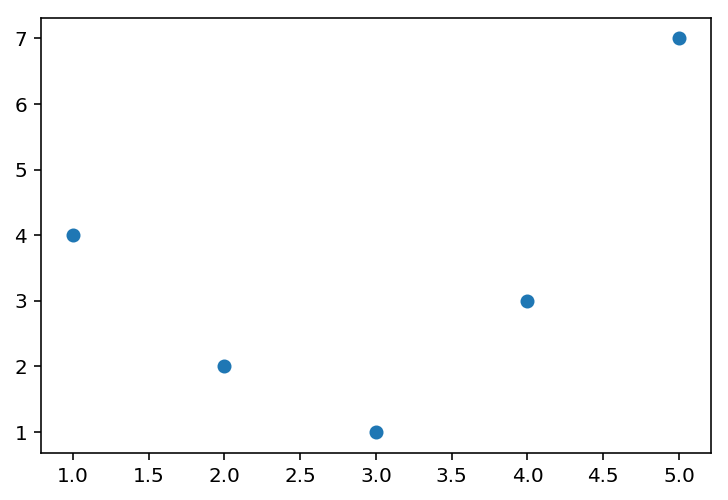

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 2, 1, 3, 7])
plt.scatter(x, y);

Si ajustamos una recta a los datos usando ``LinearRegression`` obtendremos un resultado óptimo:

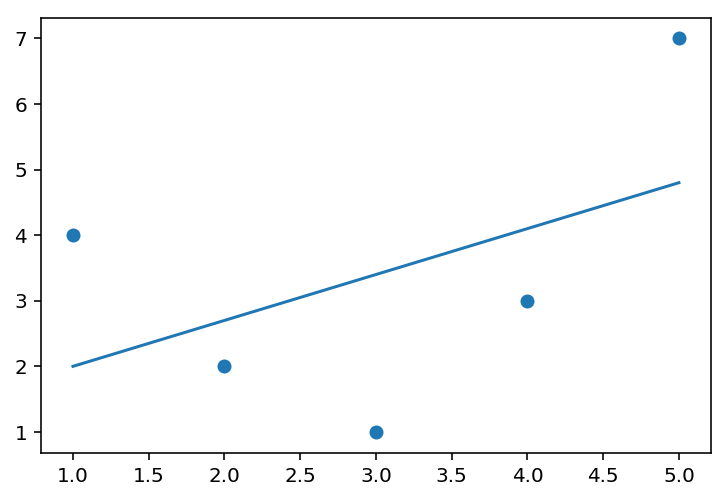

In [3]:
from sklearn.linear_model import LinearRegression
X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, yfit);

Es óptimo, pero también queda claro que necesitamos un modelo más sofisticado para describir la relació entre $x$ e $y$.

Una manera de lograrlo es transformando los datos, agregando columnas o características adicionales que le den más flexibilidad al modelo. Por ejemplo, podemos agregar características polinomiales de la siguiente forma:

In [4]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)
print(X2)

[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]]


Esta matriz de características _derivada_ tiene una columna que representa a $x$, una segunda columna que representa $x^2$, y una tercera que representa $x^3$.
Calcular una regresión lineal en esta entrada da un ajuste más cercano a nuestros datos:

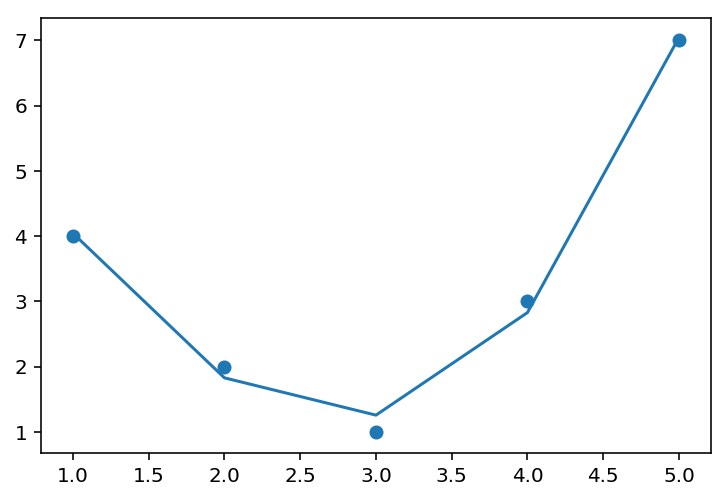

In [5]:
model = LinearRegression().fit(X2, y)
yfit = model.predict(X2)
plt.scatter(x, y)
plt.plot(x, yfit);

La idea de mejorar un modelo sin cambiarlo, sino que transformando la entrada que recibe, es fundamental para muchas de las técnicas de machine learning más poderosas.
Exploraremos más esta idea en la clase de Regresión Lineal. 
Este camino es motivante y se puede generalizar con las técnicas conocidas como _métodos de kernel_, que exploraremos en la clase de _Support Vector Machines_ (SVM).

## Imputación de Datos Faltantes

Una necesidad común en la ingeniería de características es la manipulación de datos faltantes.
En clases anteriores es posible que hayan visto el valor `NaN` en un `DataFrame`, utilizado para marcar valores que no existen.
Por ejemplo, podríamos tener un dataset que se vea así:

In [7]:
from numpy import nan
X = np.array([[ nan, 0,   3  ],
              [ 3,   7,   9  ],
              [ 3,   5,   2  ],
              [ 4,   nan, 6  ],
              [ 8,   8,   1  ]])
y = np.array([14, 16, -1,  8, -5])

Antes de aplicar un modelo a estos datos necesitamos reemplazar esos datos faltantes con algún valor apropiado de relleno.
Esto es conocido como _imputación_ de valores faltantes, y las estrategias para hacerlo varían desde las más simples (como rellenar con el promedio de cada columna) hasta las más sofisticadas (como completar la matrix con un modelo robusto para esos casos). Estos últimos enfoques suelen ser específicos para cada aplicación, así que no los veremos en el curso.

La clase `Imputer` de Scikit-Learn provee en enfoque base de imputación que calcula el promedio, la media, o el valor más frecuente:

In [9]:
from sklearn.preprocessing import Imputer
imp = Imputer(strategy='mean')
X2 = imp.fit_transform(X)
X2

array([[4.5, 0. , 3. ],
       [3. , 7. , 9. ],
       [3. , 5. , 2. ],
       [4. , 5. , 6. ],
       [8. , 8. , 1. ]])

Como vemos, al aplicar el imputador los dos valores que faltaban fueron reemplazados por el promedio de los valores presentes en las columnas respectivas. 
Ahora que tenemos una matriz sin valores faltantes, podemos usarla con la instancia de un modelo, en este caso, una regresión lineal:

In [12]:
model = LinearRegression().fit(X2, y)
model.predict(X2)

array([13.14869292, 14.3784627 , -1.15539732, 10.96606197, -5.33782027])

## Cadena de Procesamiento (_Pipeline_)

Considerando los ejemplos que hemos visto, es posible que sea tedioso hacer cada una de estas transformaciones a mano. En ocasiones querremos automatizar la cadena de procesamiento para un modelo. Imagina una secuencia como la siguiente:

1. Imputar valores usando el promedio.
2. Transformar las características incluyendo un factor cuadrático.
3. Ajustar una regresión lineal.

Para encadenar estas etapas Scikit-Learn provee una clase ``Pipeline``, que se usa como sigue:

In [13]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(Imputer(strategy='mean'),
                      PolynomialFeatures(degree=2),
                      LinearRegression())

Esta cadena o _pipeline_ se ve y actúa como un objeto estándar de Scikit-Learn, por lo que podemos utilizarla en todo lo que hemos visto hasta ahora que siga la receta de uso de Scikit-Learn.

In [15]:
model.fit(X, y)  # X con valores faltantes
print(y)
print(model.predict(X))

[14 16 -1  8 -5]
[14. 16. -1.  8. -5.]


Todos los pasos del modelo se aplican de manera automática.

¡Ojo! Por simplicidad hemos aplicado el modelo a los mismos datos con los que lo hemos entrenado, por eso el resultado es perfecto (vean el material de la clase pasada para recordar por qué esto no es un buen criterio para evaluar el modelo).

En las próximas clases seguiremos utilizando _Pipelines_ para estructurar nuestro análisis.

![](figures/PDSH-cover.png)

Este notebook contiene un extracto del libro [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) por Jake VanderPlas; el contenido también está disponible en [GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).

El texto se distribuye bajo una licencia [CC-BY-NC-ND](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), y el código se distribuye bajo la licencia [MIT](https://opensource.org/licenses/MIT). Si te parece que este contenido es útil, por favor considera apoyar el trabajo [comprando el libro](http://shop.oreilly.com/product/0636920034919.do).

Traducción al castellano por [Eduardo Graells-Garrido](http://datagramas.cl), liberada bajo las mismas condiciones.